# MNIST patches

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

## Pad images with 5x5 padding

In [71]:
kernel_size = 5
train_images_padded = np.pad(train_images, ((0, 0), (kernel_size - 1, kernel_size - 1), (kernel_size - 1, kernel_size - 1)))
train_images_padded.shape

(60000, 36, 36)

In [72]:
def make_patches(image, p=5):
    width, height = image.shape
    patches = np.random.randn((width - p + 1) * (height - p + 1), p, p)
    for i in range(width - p + 1):
        for j in range(height - p + 1):
            patches[i * (height - p + 1) + j] = image[i:i + p, j:j + p]
            
    return patches

for img in train_images_padded[:1]:
    patches = make_patches(img)
patches.shape

(1024, 5, 5)

In [84]:
def out_size(img_size, kernel_size, stride, padding):
    return (img_size + 2 * padding - (kernel_size - 1) - 1) // stride + 1

def conv2d_patches(img, kernel_size=(5, 5), stride=1, padding=0):
    (img_width, img_height) = img.shape
    (kernel_width, kernel_height) = kernel_size
    out_width, out_height = out_size(img_width, kernel_width, stride, padding), out_size(img_height, kernel_height, stride, padding)

    padded_img = np.pad(img, ((padding, padding), (padding, padding)))
    out = np.empty((out_width, out_height, kernel_width, kernel_height))
    for i, x in enumerate(range(0, out_width, stride)):
        for j, y in enumerate(range(0, out_height, stride)):
            out[i, j] = padded_img[x:x + kernel_width, y:y + kernel_height]
    return out

wolla = conv2d_patches(train_images[0])

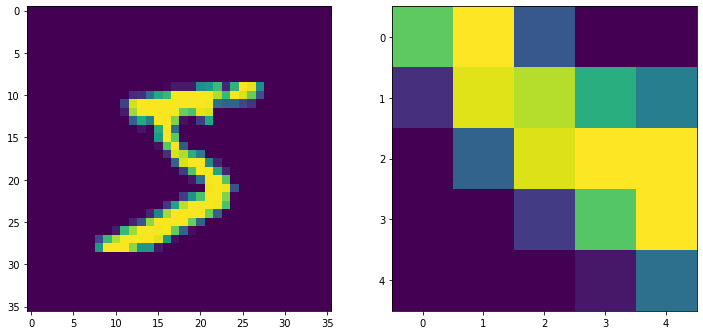

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(train_images_padded[0])
axs[1].imshow(wolla[12, 12])

## Neuron model

In [92]:
rng = np.random.default_rng()

class LIFEnsemble:
    
    def __init__(self, num_pixels, num_neurons):
        self.exc_weights = rng.uniform(size=(num_neurons, num_pixels))
        self.inh_weights = np.zeros((num_neurons, num_neurons))
        
        self.membrane_potential = np.zeros(num_neurons)
        self.input_current = np.zeros(num_neurons)
        self.thresholds = np.full(num_neurons, fill_value=5)
        self.spikes = [np.zeros(num_neurons)]
        
        self.alpha = 0.01
        self.beta = 0.0001
        self.rho = 0.05
        self.gamma = 0.02
        
    def step(self, pixels):
        self.input_current = self.exc_weights @ pixels - self.inh_weights @ self.spikes[-1]
        self.membrane_potential = self.input_current - self.membrane_potential
        
        self.spikes.append(self.membrane_potential > self.thresholds)
        self.membrane_potential *= ~self.spikes[-1]
        
    def update(self, pixels):
        n_i = np.stack(self.spikes[1:]).sum(0)
        n_m = np.stack(self.spikes[1:]).sum(0)
        
        self.inh_weights += self.alpha * (np.outer(n_i, n_m) - self.rho**2)
        self.inh_weights[np.diag_indices_from(self.inh_weights)] = 0
        self.exc_weights += self.beta * (np.outer(n_i, pixels) - n_i**2 @ self.exc_weights)
        self.thresholds += self.gamma * (n_i - self.rho)
        self.spikes = self.spikes[:1]
        

In [93]:
ensemble = LIFEnsemble(25, 16)

In [98]:
image = train_images[0]
patches = conv2d_patches(image) / 255
for patch in patches:
    for time_step in range(20):
        ensemble.step(patch)
    
    ensemble.update(patch)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 16)